In [1]:
import numpy as np
import pandas as pd
import scipy.constants as cst
import matplotlib.pyplot as plt
from scipy.interpolate import spline  
from jupyterthemes import jtplot
jtplot.style(theme='grade3',ticks=True, grid=False,context='poster',fscale=1.5, spines=True, gridlines='--')
%matplotlib inline

In [15]:
m_Rb=1.44316*10**(-25)
Wx=62*2*np.pi
Wy=62*2*np.pi
U=760*cst.h*10**9/cst.Boltzmann
lamda=1064*10**(-9)
chmu=0.5*m_Rb*0.25*lamda**2*10**9/cst.Boltzmann#in nk
maxn=5
Er=(cst.hbar*2*np.pi/lamda)**2/(2*m_Rb)
print('U is %f nK'%U)
print('1 Er is %0.2f nK, %0.2f Hz'%(Er*10**9/cst.Boltzmann,Er/cst.h))#np.sqrt(U/chmu/Wx/Wy)

U is 36.474259 nK
1 Er is 97.32 nK, 2027.81 Hz


In [16]:
class lattice(object):
    nlist=np.linspace(0,maxn-1,maxn)
    
    def __init__(self,T,latticesites,mu):
        self.Temp=T
        self.latticesites=latticesites
        self.mu=mu
        self.stru=np.ones((self.latticesites,self.latticesites,maxn))
        self.En=0.5*U*self.nlist*(self.nlist-1)
        self.E=-self.stru*self.En+chemipotential(self.mu).reshape(self.latticesites,self.latticesites,1)*(self.stru*self.nlist)
        self.Zfu=np.sum(np.exp(self.E/self.Temp),axis=-1).reshape(self.latticesites,self.latticesites,1)
        self.Pn= np.exp(self.E/self.Temp)/self.Zfu
        self.Nav=np.sum(self.stru*self.nlist*self.Pn,axis=-1)
        self.Nmod=np.sum(self.stru*np.mod(self.nlist,2)*self.Pn,axis=-1)
        self.Nt=np.sum(self.Nav)

        
def findmu(N,latticesites,T,er0=0.005,P=5):
    u0=10
    latticet=lattice(T,latticesites,u0)
    Nt=latticet.Nt
    er=np.abs(N-Nt)/N
    while(er>er0):
        u0=u0+(N-Nt)/N*10
        latticet=lattice(T,latticesites,u0)
        Nt=latticet.Nt
        er=np.abs(N-Nt)/N
    return u0,er*N

def calNatom(Temp,latticepoints,mu):
    numsite={}
    nlist=np.linspace(0,maxn-1,maxn)
    stru=np.ones((latticepoints,latticepoints,maxn))
    En=0.5*U*nlist*(nlist-1)
    xi=np.linspace(-(latticesites-1)/2,(latticesites-1)/2,latticepoints)
    yi=np.linspace(-(latticesites-1)/2,(latticesites-1)/2,latticepoints)
    E=-stru*En+chemipotential(mu,xi,yi).reshape(latticepoints,latticepoints,1)*(stru*nlist)
    Zfu=np.sum(np.exp(E/Temp),axis=-1).reshape(latticepoints,latticepoints,1)
    Pn= np.exp(E/Temp)/Zfu
    Nav=np.sum(stru*nlist*Pn,axis=-1)
    Nmod=np.sum(stru*np.mod(nlist,2)*Pn,axis=-1)
    Nvar=Nmod*(1-Nmod)
    Nt=np.sum(Nav)
    Entropy=-Nmod*np.log2(Nmod)-(1-Nmod)*np.log2(1-Nmod)
    numsite['Nvar']=Nvar
    numsite['Nav']=Nav
    numsite['Nmod']=Nmod
    numsite['Nt']=Nt
    numsite['Entropy']=Entropy
    return numsite

u is 21.35 nK
Atom Number Error is 1.044689
CPU times: user 1.1 s, sys: 88.5 ms, total: 1.19 s
Wall time: 943 ms
Parser   : 272 ms


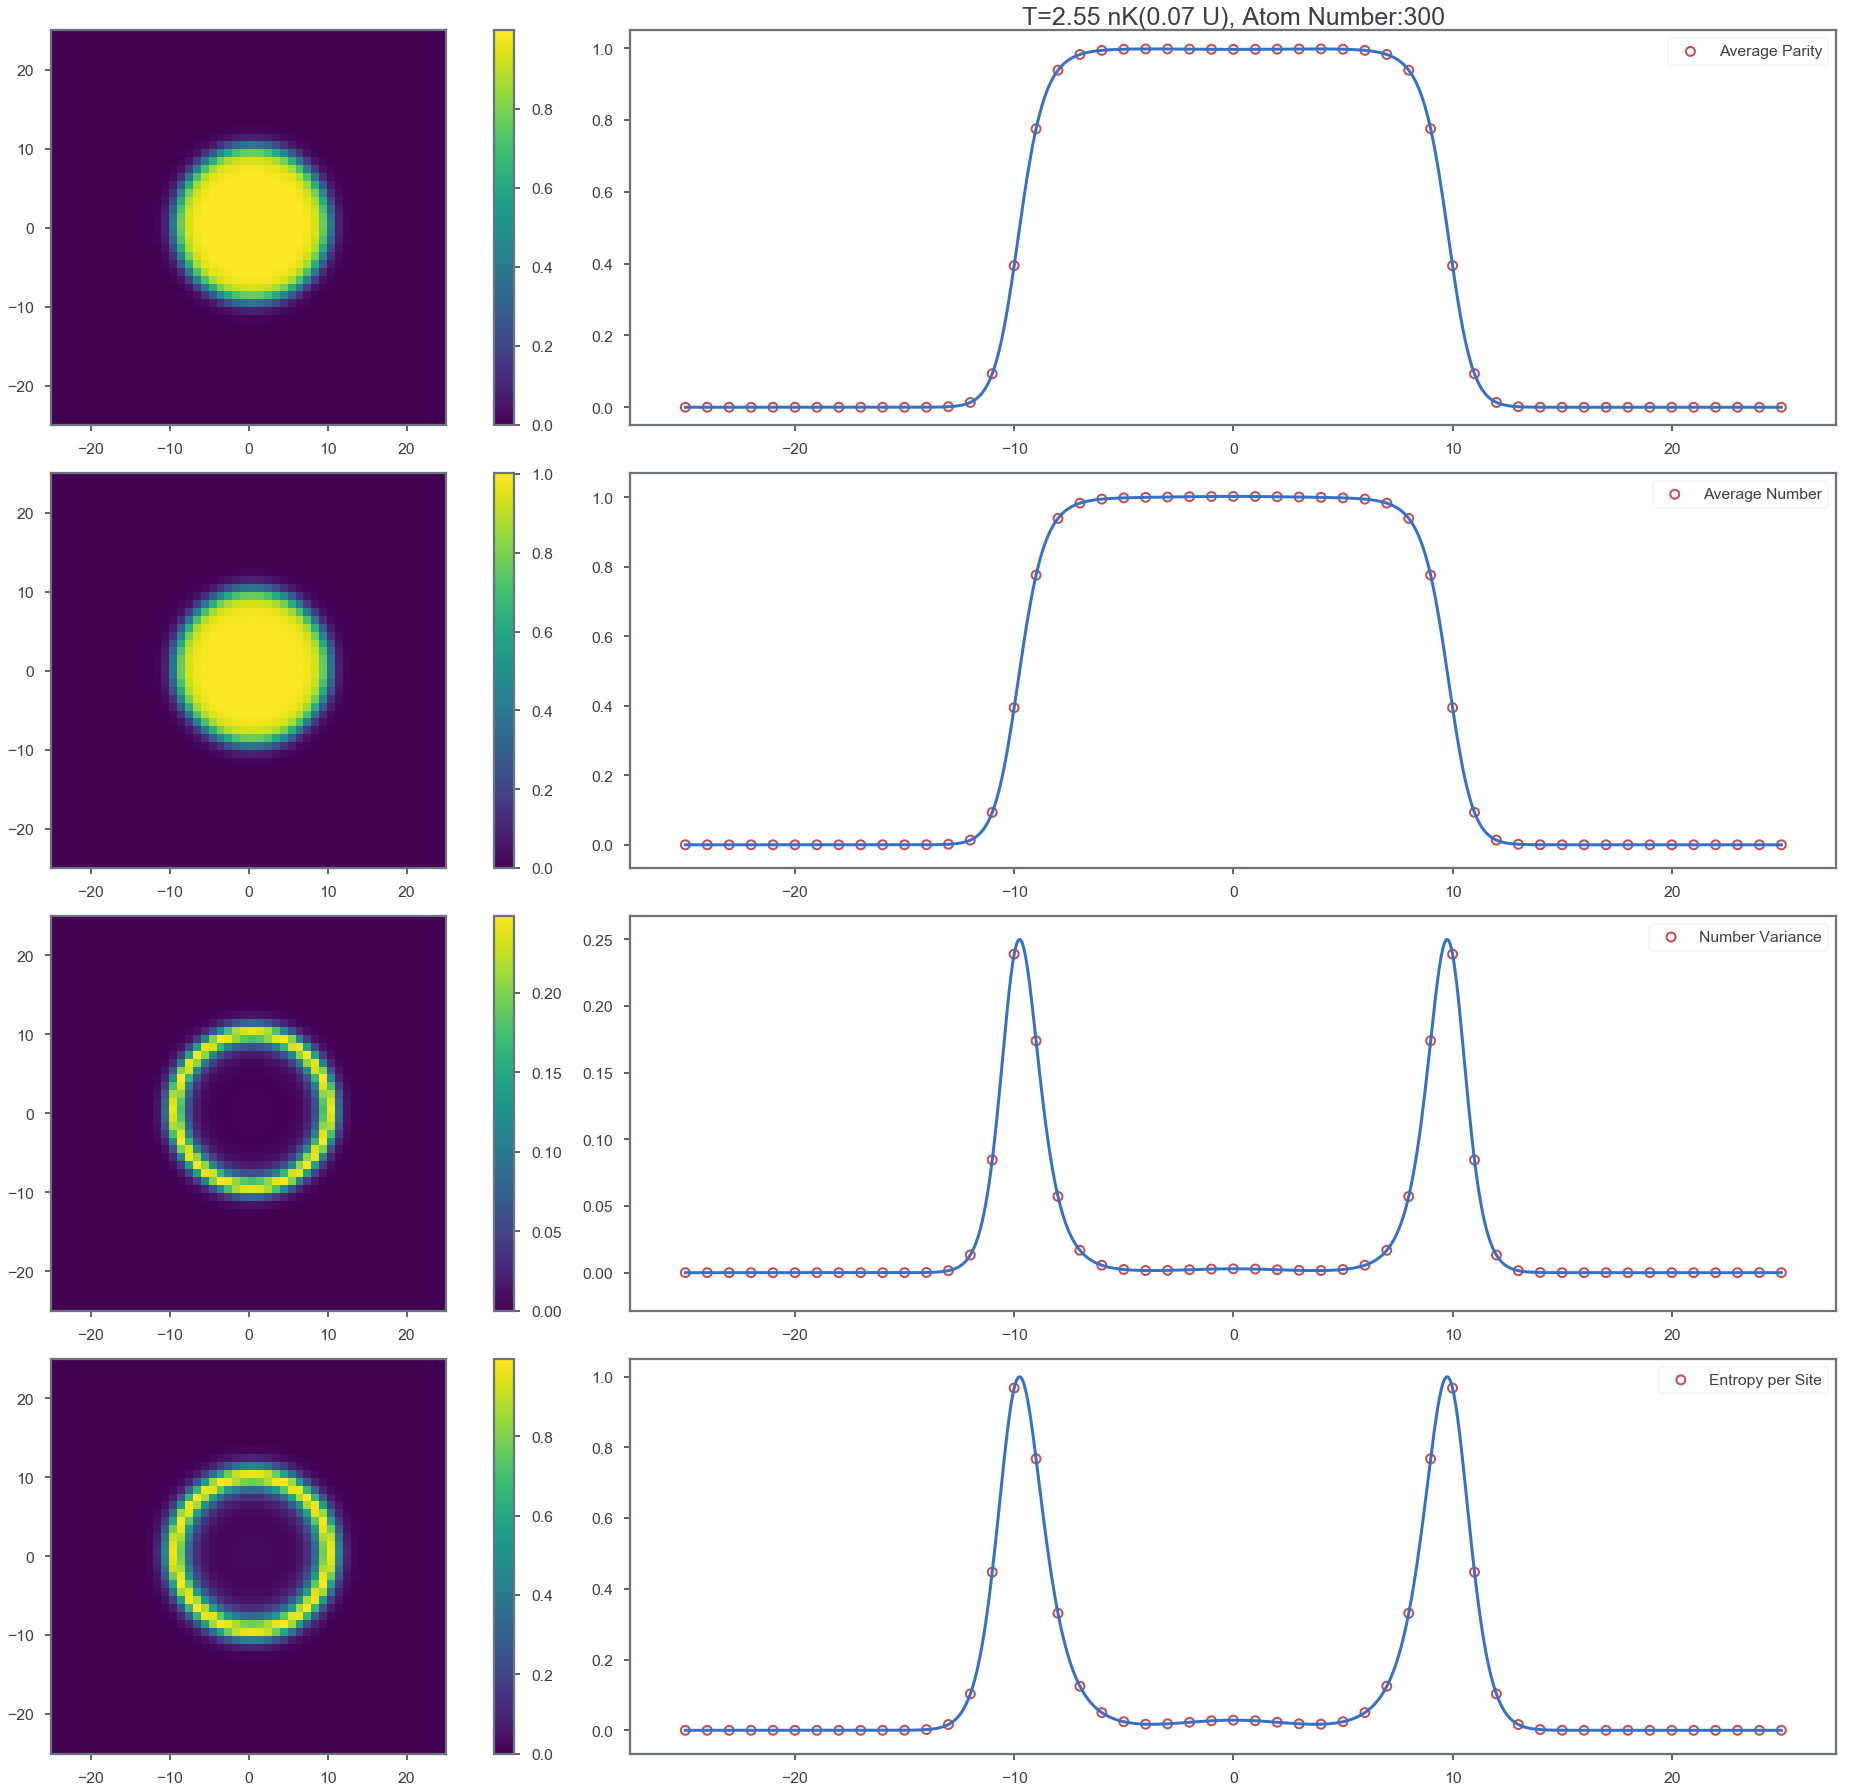

<Figure size 720x720 with 0 Axes>

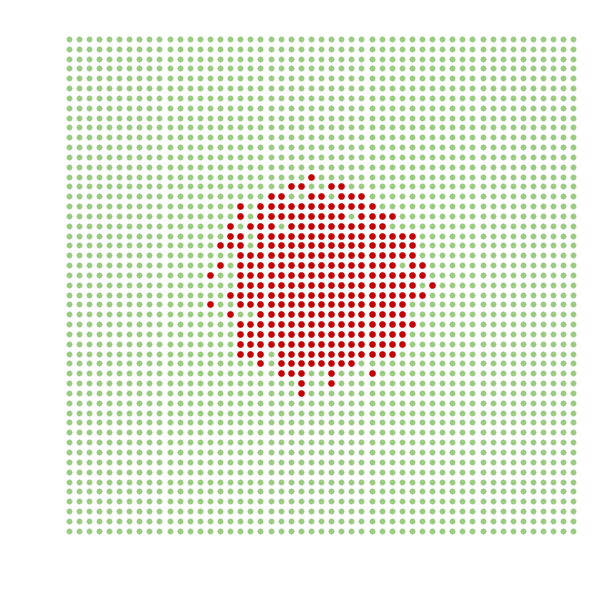

In [18]:
%%time
N=300
T=0.07*U #(nk)
latticesites=51
latticepoints=600
xi=np.linspace(-(latticesites-1)/2,(latticesites-1)/2,latticepoints)
yi=np.linspace(-(latticesites-1)/2,(latticesites-1)/2,latticepoints)
x=np.linspace(-(latticesites-1)/2,(latticesites-1)/2,latticesites)
y=np.linspace(-(latticesites-1)/2,(latticesites-1)/2,latticesites)
xx,yy=np.meshgrid(x,y,indexing='ij')
def chemipotential(u,xi=x,yi=y):
    xx,yy=np.meshgrid(xi,yi,indexing='ij')
    ur=u-chmu*((Wx*xx)**2+(Wy*yy)**2)
    return ur

realmu,Ner=findmu(N,latticesites,T,P=40)
print('u is %0.2f nK'%realmu)
print('Atom Number Error is %f'%Ner)
    
lattice1=lattice(T,latticesites,realmu)
theors=calNatom(T,latticepoints,realmu)
NPar=lattice1.Nmod
loch=x#-chemipotential(realmu)[int(latticesites/2-0.5)]/U
fig,axs=plt.subplots(4,2,figsize=(35,25))
#fig.suptitle('T=%f nK, Atom Number:%d'%(T,N))
#plt.figure(figsize=(10,8))
axs[0,0].set_aspect('equal', 'box')
axs[0,1].set_ylim(((-0.05,1.05)))
img1=axs[0,0].pcolor(x,y,NPar)
fig.colorbar(img1,ax=axs[0,0],fraction=0.046, pad=0.04)
#plt.figure(figsize=(10,8))
axs[0,1].set_title('T=%0.2f nK(%0.2f U), Atom Number:%d'%(T,T/U,N),fontsize=25)
axs[0,1].scatter(loch,lattice1.Nmod[int(latticesites/2-0.5)],color='',edgecolors='r',s=80,linewidths=2,label='Average Parity')
axs[0,1].plot(xi,theors['Nmod'][int(latticepoints/2)],'-',linewidth=3)
axs[0,1].legend(loc='best')
axs[1,0].set_aspect('equal', 'box')
img2=axs[1,0].pcolor(x,y,lattice1.Nav)
fig.colorbar(img2,ax=axs[1,0],fraction=0.046, pad=0.04)
axs[1,1].scatter(loch,lattice1.Nav[int(latticesites/2-0.5)],color='',edgecolors='r',s=80,linewidths=2,label='Average Number')
axs[1,1].plot(xi,theors['Nav'][int(latticepoints/2)],'-',linewidth=3)
axs[1,1].legend(loc='best')
axs[2,0].set_aspect('equal', 'box')
img3=axs[2,0].pcolor(x,y,NPar*(1-NPar))
fig.colorbar(img3,ax=axs[2,0],fraction=0.046, pad=0.04)
axs[2,1].scatter(loch,(NPar*(1-NPar))[int(latticesites/2-0.5)]
              ,color='',edgecolors='r',s=80,linewidths=2,label='Number Variance')
axs[2,1].plot(xi,theors['Nvar'][int(latticepoints/2)],'-',linewidth=3)
axs[2,1].legend(loc='best')
axs[3,0].set_aspect('equal', 'box')
img4=axs[3,0].pcolor(x,y,-NPar*np.log2(NPar)-(1-NPar)*np.log2(1-NPar))
fig.colorbar(img4,ax=axs[3,0],fraction=0.046, pad=0.04)
axs[3,1].scatter(loch,-NPar[int(latticesites/2-0.5)]*np.log2(NPar[int(latticesites/2-0.5)])
              -(1-NPar)[int(latticesites/2-0.5)]*np.log2((1-NPar)[int(latticesites/2-0.5)]),color='',edgecolors='r',s=80,linewidths=2,label='Entropy per Site')
axs[3,1].plot(xi,theors['Entropy'][int(latticepoints/2)],'-',linewidth=3)
axs[3,1].legend(loc='best')
plt.tight_layout()
plt.figure(figsize=(10,10))
randi=np.random.random((latticesites,latticesites))
xfill,yfill=np.where((randi-lattice1.Nmod)<0)
xem,yem=np.where((randi-lattice1.Nmod)>=0)
plt.figure(figsize=((10,10)))
plt.grid(False)
#plt.axes().set_aspect('equal', 'box')
plt.axis('off')

plt.scatter(xfill,yfill,color=(196/255, 0, 0),s=40,zorder=3)
plt.scatter(xem,yem,color=(153/255,204/255,128/255),s=30)#(0.15,0.38,0.61)

# plt.vlines(np.arange(latticesites+1),0,latticesites,colors=(255/255,255/255,240/255),zorder=2)
# plt.hlines(np.arange(latticesites+1),0,latticesites,colors=(255/255,255/255,240/255),zorder=1)

plt.savefig('simulateatom.pdf')

CPU times: user 3.3 s, sys: 619 ms, total: 3.92 s
Wall time: 2.07 s


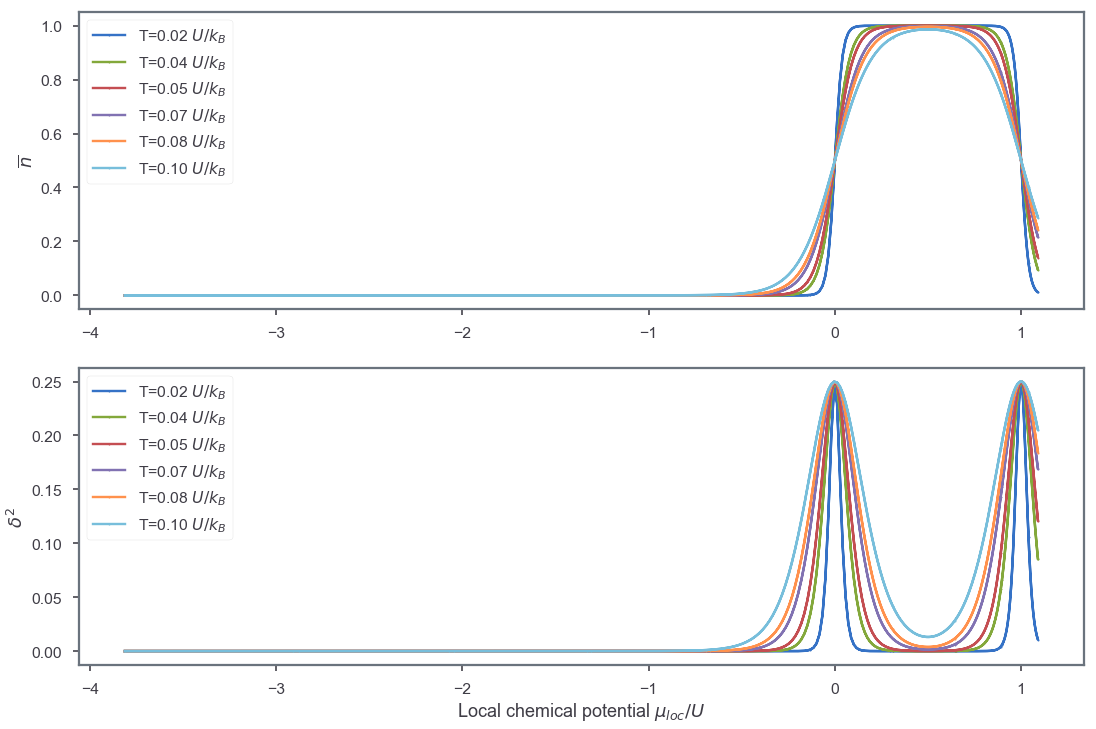

In [104]:
%%time
latticepoints=600
xi=np.linspace(-(latticesites-1)/2,(latticesites-1)/2,latticepoints)
tlist=np.array([0.02,0.04,0.05,0.07,0.08,0.1])*U
fig=plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(211)
#ax1.set_xlabel('Local chemical potential $\mu_{loc}/U$')
ax1.set_ylabel('$\overline{n}$')
ax2 = fig.add_subplot(212)
ax2.set_xlabel('Local chemical potential $\mu_{loc}/U$')
ax2.set_ylabel('$\delta^2$')
for T in tlist:
    ax1.plot(chemipotential(realmu,xi,xi)[int(latticepoints/2)]/U,calNatom(T,latticepoints,realmu)['Nmod'][int(latticepoints/2)],'.-',
             label='T=%0.2f $U/k_B$'%(T/U),markevery=int(latticepoints/20),markersize=4)
    ax2.plot(chemipotential(realmu,xi,xi)[int(latticepoints/2)]/U,calNatom(T,latticepoints,realmu)['Nvar'][int(latticepoints/2)],'.-',
             label='T=%0.2f $U/k_B$'%(T/U),markevery=int(latticepoints/20),markersize=4)
ax1.legend(loc='best')
ax2.legend(loc='best')
#ax2=ax1.twinx()
#ax2.plot(xi,chemipotential(realmu,xi,xi)[int(latticepoints/2)]/U,'go-',markevery=int(latticepoints/20),markersize=4)

u is 8.79 nK
Atom Number Error is 0.001953
u is 13.56 nK
Atom Number Error is 0.074823
u is 18.16 nK
Atom Number Error is 0.072472
u is 22.67 nK
Atom Number Error is 0.120228
u is 27.05 nK
Atom Number Error is 0.134030
u is 31.11 nK
Atom Number Error is 0.141992
CPU times: user 2.55 s, sys: 514 ms, total: 3.06 s
Wall time: 1.69 s


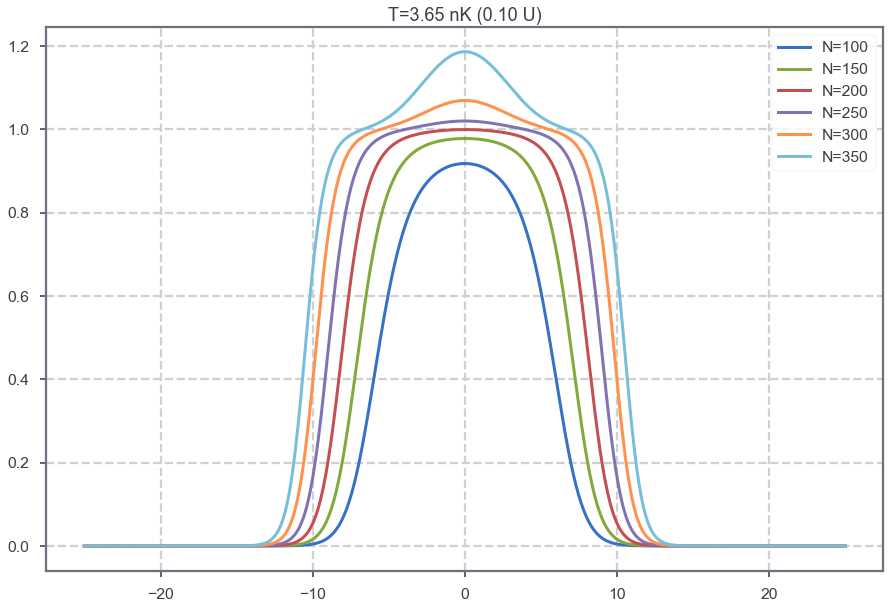

In [105]:
%%time
Nlist=list(range(100,400,50))
T=0.1*U #(nk)
latticesites=51
latticepoints=600
xi=np.linspace(-(latticesites-1)/2,(latticesites-1)/2,latticepoints)
yi=np.linspace(-(latticesites-1)/2,(latticesites-1)/2,latticepoints)
x=np.linspace(-(latticesites-1)/2,(latticesites-1)/2,latticesites)
y=np.linspace(-(latticesites-1)/2,(latticesites-1)/2,latticesites)
xx,yy=np.meshgrid(x,y,indexing='ij')
def chemipotential(u,xi=x,yi=y):
    xx,yy=np.meshgrid(xi,yi,indexing='ij')
    ur=u-chmu*((Wx*xx)**2+(Wy*yy)**2)
    return ur

#plt.ylim(((-0.05,1.05)))
plt.figure(figsize=(15,10))
plt.title('T=%0.2f nK (%0.2f U)'%(T,T/U))
plt.grid(True)
for N in Nlist:
    realmu,Ner=findmu(N,latticesites,T,P=40)
    print('u is %0.2f nK'%realmu)
    print('Atom Number Error is %f'%Ner)
    
    theors=calNatom(T,latticepoints,realmu)
    #fig,axs=plt.subplots(4,2,figsize=(35,25))
    #fig.suptitle('T=%f nK, Atom Number:%d'%(T,N))
    #plt.figure(figsize=(10,8))
    #plt.figure(figsize=(10,8))
    plt.plot(xi,theors['Nav'][int(latticepoints/2)],'-',linewidth=3,label='N=%d'%N)
plt.legend(loc='best')

u is 27.49 nK
Atom Number Error is 0.133894
u is 27.27 nK
Atom Number Error is 0.115543
u is 26.95 nK
Atom Number Error is 0.121202
u is 26.39 nK
Atom Number Error is 0.141346
u is 25.65 nK
Atom Number Error is 0.117132
CPU times: user 1.81 s, sys: 713 ms, total: 2.53 s
Wall time: 2.34 s


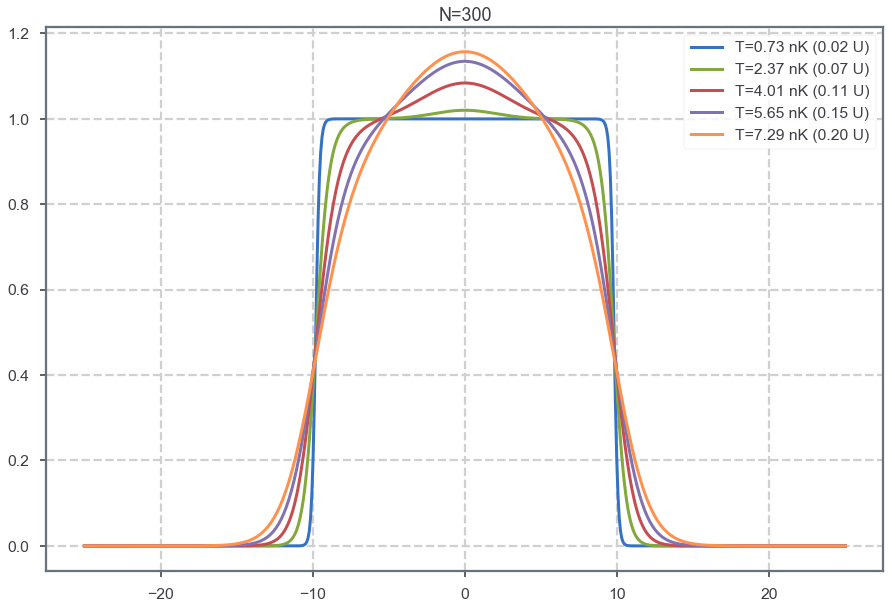

In [164]:
%%time
N=300
Tlist=np.linspace(0.02,0.2,5)*U #(nk)
latticesites=51
latticepoints=600
xi=np.linspace(-(latticesites-1)/2,(latticesites-1)/2,latticepoints)
yi=np.linspace(-(latticesites-1)/2,(latticesites-1)/2,latticepoints)
x=np.linspace(-(latticesites-1)/2,(latticesites-1)/2,latticesites)
y=np.linspace(-(latticesites-1)/2,(latticesites-1)/2,latticesites)
xx,yy=np.meshgrid(x,y,indexing='ij')
def chemipotential(u,xi=x,yi=y):
    xx,yy=np.meshgrid(xi,yi,indexing='ij')
    ur=u-chmu*((Wx*xx)**2+(Wy*yy)**2)
    return ur

#plt.ylim(((-0.05,1.05)))
plt.figure(figsize=(15,10))
plt.title('N=%d'%N)
plt.grid(True)
for T1 in Tlist:
    realmu,Ner=findmu(N,latticesites,T1,P=40)
    print('u is %0.2f nK'%realmu)
    print('Atom Number Error is %f'%Ner)
    
    theors=calNatom(T1,latticepoints,realmu)
    #fig,axs=plt.subplots(4,2,figsize=(35,25))
    #fig.suptitle('T=%f nK, Atom Number:%d'%(T,N))
    #plt.figure(figsize=(10,8))
    #plt.figure(figsize=(10,8))
    plt.plot(xi,theors['Nav'][int(latticepoints/2)],'-',linewidth=3,label='T=%0.2f nK (%0.2f U)'%(T1,T1/U))
plt.legend(loc='best')